<img src="http://ec2-34-212-11-29.us-west-2.compute.amazonaws.com/InternalWiki/images/2/2e/CML_Logo.gif">

## Quick Start Tutorial for the Better Oscillation Detection Method
This tutorial provides a brief example for using CML's P_episode package for detecting true oscillations in electrophysiological data.
The method is adapted from Caplan Et Al (2001), *Distinct Patterns of Brain Oscillations Underlie Two Basic Parameters of Human Maze Learning*

In [1]:
import numpy as np
import pandas as pd
import cmlreaders as cml
import P_episode as pep
import scipy.stats as scp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from ptsa.data.filters import ButterworthFilter
import warnings
warnings.simplefilter('ignore')

/home1/jrudoler/anaconda3/envs/cml37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Pick a subject, create a CMLReader object, and use it to load events and electrode configurations

In [2]:
subject = 'R1195E'
reader = cml.CMLReader(subject = subject, experiment = 'FR1', session = 0)
pairs = reader.load("pairs")
all_events = reader.load('task_events')

Use events and electrodes to load EEG (in this case, bipolar) for a single electrode pair.

In [3]:
bip = reader.load_eeg(scheme = pairs[pairs.label =='5LD3-5LD4']).to_ptsa().mean(['event', 'channel'])
bip = ButterworthFilter(bip, freq_range=[58., 62.], filt_type='stop', order=4).filter()

In [4]:
pep.P_episode?

Init signature: pep.P_episode(events, eeg, relstart=300, relstop=1301, width=5, sr=None, lowfreq=2, highfreq=120, numfreqs=30, percentthresh=0.95, numcyclesthresh=3)
Docstring:     
An object for handling the Better Oscillation Detection Methods
**Currently only handles encoding events, compatible with FR1 data**

Parameters:
    events - a pandas DataFrame containing the event or events (from the same session) being analyzed
    eeg - a ptsa timeseries object containing EEG data

    rel_start = beginning of event in ms relative to word onset
    rel_stop = end of event in ms relative to word onset

    width - the length of the MorletWaveletFilter
    sr - the sample rate for the EEG signal. If none, it uses CMLReader to find it 
    lowfreq - the lowest frequency to be calculated
    highfreq - the highest frequency to be calculated
    numfreqs - the number of frequencies logspaced between lowfreq and highfreq to be calculated
    
    percentthresh - Percentile (default 95th) of c

Initialize a P_episode class object, which will automatically perform wavelet decomposition. 

In [5]:
bosc = pep.P_episode(all_events, bip, relstart = 300, relstop = 1301, width=5, sr=bip.samplerate.values, 
                     lowfreq=2, highfreq=120, numfreqs=30, percentthresh=.95, numcyclesthresh=3)

CPP total time wavelet loop:  5.4049224853515625


Visualize the background fit with built in method background_fit(). The plot_type parameter allows you to either specify a list index to plot or to average over all lists in the session (and report the average $R^2$ metric)

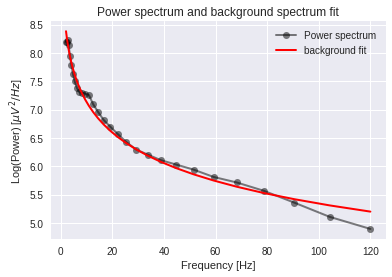

In [25]:
bosc.background_fit('list', 0)

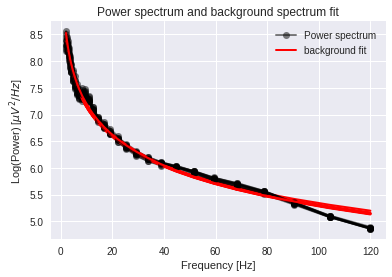

In [27]:
for i in range(10):
    bosc.background_fit('list', i)

0.989637461073033

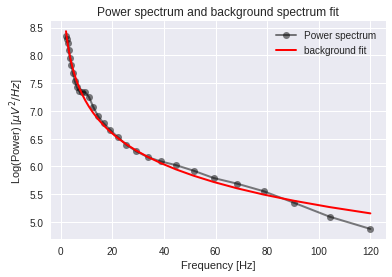

In [6]:
bosc.background_fit('session')

You can also view the EEG trace with true oscillatory periods highlighted in red. The raw_trace() method takes a frequency *index* as a required argument. You can access the available frequencies with bosc.freqs. 

In [22]:
bosc.freqs.round(2)

array([  2.  ,   2.3 ,   2.65,   3.05,   3.52,   4.05,   4.67,   5.37,
         6.19,   7.13,   8.21,   9.45,  10.88,  12.54,  14.44,  16.63,
        19.15,  22.05,  25.39,  29.24,  33.68,  38.78,  44.67,  51.44,
        59.24,  68.22,  78.57,  90.48, 104.2 , 120.  ])

In [24]:
list(bosc.freqs.round(2)).index(9.45)

11

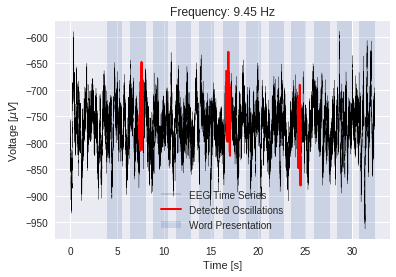

In [16]:
bosc.raw_trace(freq_idx=11, list_idx=0, subplot = False)

Zooming in on a region of interest is easy enough with plt.xlim(start, end)

(15, 20)

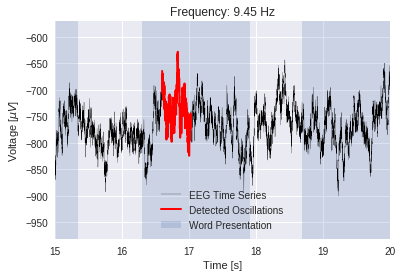

In [17]:
bosc.raw_trace(11, subplot = False)
plt.xlim(15, 20)

To see the signal filtered, which is a bit more intuitive, use the 'filtered' parameter

CPP total time wavelet loop:  4.973617076873779


(15, 20)

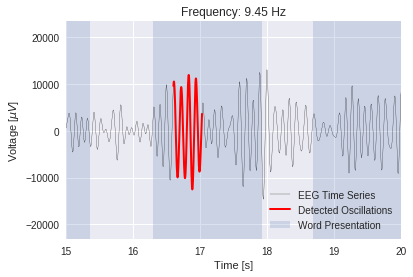

In [19]:
bosc.raw_trace(11, subplot = False, filtered = True)
plt.xlim(15, 20)

Now we can calculate p_episode averaged for all events of interest, for recalled events, for non-recalled events, and ttest scores comparing recalled and not-recalled

In [33]:
all_pep, rec, nrec, t = pep.calc_subj_pep('R1195E', ['5LD3-5LD4'], save = False)

Subject:  R1195E
['5LD3-5LD4']
['5LD3', '5LD4']
Loading session 0 EEG
Applying BOSC method!
CPP total time wavelet loop:  4.473853349685669
0.28
(30,)
Loading session 1 EEG
Applying BOSC method!
CPP total time wavelet loop:  4.089690208435059
0.2733333333333333
(2, 30)
Loading session 2 EEG
Applying BOSC method!
CPP total time wavelet loop:  3.8690621852874756
0.30444444444444446
(3, 30)
3 sessions
900 total events: 274 recalled and 626 non-recalled


This plotting method needs work - it will not work for other users just yet, but I've included it here to get an idea of how this data can be visualized.

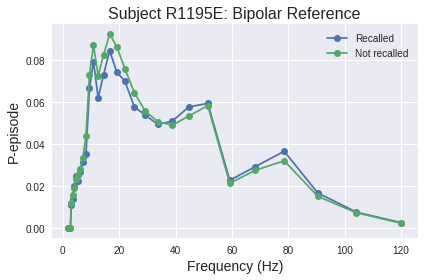

In [34]:
pep.plot_pepisode('R1195E', 'bip')